## 关键要点

清洗这个项目的数据时要牢记几个要点：  
- 我们只需要含有图片的原始评级 (不包括转发)。尽管数据集中有 5000 多条数据，但是并不是所有都是狗狗评分，并且其中有一些是转发。（含图片、是狗狗评分、原始评级（不要转发的））
- 本项目的要求只是评估和清理此数据集中的至少 8 个质量问题和至少 2 个整洁度问题。
- 合并三个数据片段


## 完善twitter档案
WeRateDogs 的推特档案包括 5000 多条推特的基本信息。  
档案中有一列包含每个推特的文本，我用这一列数据提取了评分、狗的名字和“地位”（即 doggo、floofer、pupper 和 puppo）——这使数据得以“完善”。在这 5000 多条中，我只筛选出了 2356 条包含评分的推特数据。

注意其中的评分、狗的名字和地位都有不正确的，如果想用它们进行分析和可视化，你需要评估和清洗这些列。

twitter-archive-enhanced.csv

## 通过推特 API 获取附加数据

**转发数（retweet count）**和**喜爱数（favorite count）**
需要从推特ID中获取 tweet_json.txt

## 图像预测文件

获取的结果：一份图像预测结果表格，其中包含了预测结果的前三名，推特 ID，图像 url 以及最可信的预测结果对应的图像编号（由于推特最多包含 4 个图片，所以编号为 1 到 4）。

以该表格中的最后一行数据来理解各列数据：

   tweet_id 是推特链接的最后一部分，位于 "status/" 后面 → https://twitter.com/dog_rates/status/889531135344209921
    jpg_url 是预测的图像资源链接
    img_num 最可信的预测结果对应的图像编号 → 1 推特中的第一张图片
    p1 是算法对推特中图片的一号预测 → 金毛犬
    p1_conf 是算法的一号预测的可信度 → 95%
    p1_dog 是一号预测该图片是否属于“狗”（有可能是其他物种，比如熊、马等） → True 真
    p2 是算法对推特中图片预测的第二种可能性 → 拉布拉多犬
    p2_conf 是算法的二号预测的可信度 → 1%
    p2_dog 是二号预测该图片是否属于“狗” → True 真
    以此类推...

这个文件你需要使用 Python 的 Requests 库和以下提供的 URL 来进行编程下载。下载用的 URL：https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv 。

## 步骤

### 0. 收集数据集
Jupyter Notebook 中记录评估过程和结果，最终列出至少 8 个质量问题 和 2 个清洁度问题。

In [1]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import csv
import re
import json
from pprint import pprint
import random
import functools

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


In [2]:
# twitter-archive-enhanced.csv -> df_tae
df_tae = pd.read_csv("twitter-archive-enhanced.csv")

display.display(df_tae)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,nan,nan,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,nan,nan,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,nan,nan,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,nan,nan,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [3]:
# tweet_json.txt -> df_twt_json
df_twt_json = pd.DataFrame(columns=['tweet_id', 'jpg_url', 'img_num', 
#                                     'text', 
                                    'retweet_count', 'favorite_count'])
except_list = []
with open("tweet_json.txt") as f:

    for index, line in enumerate(f.readlines()):
        try:
            dct = json.loads(line)
            tweet_id = dct["entities"]["media"][0]['expanded_url'].split(sep='/')[-3]
            retweet_count = dct["retweet_count"]
            favorite_count = dct["favorite_count"]
            text = dct["full_text"]
            for i, d in enumerate(dct["extended_entities"]["media"],start=1):
                jpg_url = d["media_url_https"]
                img_num = i
                df_twt_json.loc[df_twt_json.shape[0]] = \
                    {'tweet_id':tweet_id, 
                     'jpg_url':jpg_url, 
                     'img_num':img_num, 
#                      'text':text, 
                     'retweet_count':retweet_count, 
                     'favorite_count':favorite_count}
        except KeyError as e:
#             print('except:', index,":\t",e)
            except_list.append(index)
df_twt_json = df_twt_json.astype({'tweet_id':np.int64,
                   'img_num':np.int64,
                   'retweet_count': np.int64,
                   'favorite_count': np.int64}, copy=False)

display.display(df_twt_json)

,tweet_id,jpg_url,img_num,retweet_count,favorite_count
0,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,8842,39492
1,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,6480,33786
2,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,4301,25445
3,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,8925,42863
4,891327558926688256,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,1,9721,41016
...,...,...,...,...,...
2939,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,41,111
2940,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,147,309
2941,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,47,128
2942,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,48,132


In [4]:
# image_predictions.tsv -> df_img_pre
import csv
import requests
url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
with requests.Session() as s:
    s.post(url)
    download = s.get('https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv')

with open('image_predictions_tmp.tsv', 'w') as f:
    f.write(download.content.decode('ascii'))

df_img_pre = pd.read_csv('image_predictions_tmp.tsv', sep='\t')
df_img_pre

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.5,True,collie,0.2,True,Shetland_sheepdog,0.1,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.5,True,miniature_pinscher,0.1,True,Rhodesian_ridgeback,0.1,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.6,True,malinois,0.1,True,bloodhound,0.1,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.4,True,redbone,0.4,True,miniature_pinscher,0.2,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.6,True,Rottweiler,0.2,True,Doberman,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.6,True,English_springer,0.2,True,German_short-haired_pointer,0.2,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.2,False,Labrador_retriever,0.2,True,spatula,0.0,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.7,True,malamute,0.1,True,kelpie,0.0,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.3,True,Pekinese,0.1,True,papillon,0.1,True


### 1. 对项目数据进行评估
数据评估主要是评估数据的质量和完整度。  
数据质量问题：

- 1、数据丢失；
- 2、数据无效；
- 3、数据不准确；
- 4、数据不一致，单位不同

数据整洁度标准：

- 1、每个变量构成一列；
- 2、每个观察结果构成一行；
- 3、每种类型的观察单位构成一个表格。

评估以下三个表格：   
- df_tae
- df_twt_json
- df_img_pre

#### 1. 评估df_tae

In [5]:
display.display(df_tae)
display.display(df_tae.describe())
for k, v in df_tae.dtypes.iteritems():
    print(k, '\t\t', v)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,nan,nan,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,nan,nan,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,nan,nan,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,nan,nan,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2356.0,78.0,78.0,181.0,181.0,2356.0,2356.0
mean,742771590321692416.0,745507917855750784.0,20141706360873220.0,772039961038007040.0,12416983653017598.0,13.1,10.5
std,68567047444761000.0,75824920044192880.0,125279666255236304.0,62369278105055600.0,95992535331517504.0,45.9,6.7
min,666020888022790144.0,665814696700723200.0,11856342.0,666104133288665088.0,783214.0,0.0,0.0
25%,678398938214475776.0,675741911993464832.0,308637448.8,718631497683582976.0,4196983835.0,10.0,10.0
50%,719627934716235776.0,703870840226598912.0,4196983835.0,780465709297995776.0,4196983835.0,11.0,10.0
75%,799337304954252288.0,825780371286566912.0,4196983835.0,820314633777061888.0,4196983835.0,12.0,10.0
max,892420643555336192.0,886266357075128320.0,840547864354918400.0,887473957103951872.0,787461778435289088.0,1776.0,170.0


tweet_id 		 int64
in_reply_to_status_id 		 float64
in_reply_to_user_id 		 float64
timestamp 		 object
source 		 object
text 		 object
retweeted_status_id 		 float64
retweeted_status_user_id 		 float64
retweeted_status_timestamp 		 object
expanded_urls 		 object
rating_numerator 		 int64
rating_denominator 		 int64
name 		 object
doggo 		 object
floofer 		 object
pupper 		 object
puppo 		 object


**质量问题1**：  
in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 的数据格式应该是int64

In [6]:
df_tae.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [7]:
df_tae.duplicated().value_counts()
# 没有重复

False    2356
dtype: int64

In [8]:
df_tae.tweet_id.duplicated().value_counts()
# tweet_id 没有重复

False    2356
Name: tweet_id, dtype: int64

检查转发的是否需要保留

可以发现其特点在于text一列中包含一个@user_id的部分外，都满足质量要求，予以保留

In [9]:
for i, row in df_tae[~df_tae['in_reply_to_user_id'].isnull()].iterrows():
    print(row.text)
    if i > 30:
        break

@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s


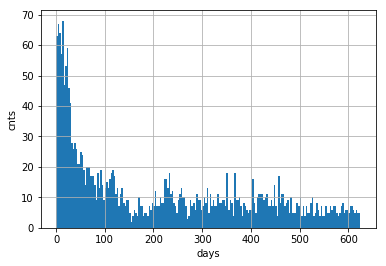

In [10]:
# 处理时间戳一列，观察twitter发送时间是否存在规律，如果中间有大块缺失，可能意味着我们丢了一段时间的数据
import datetime
for index, row in df_tae.iterrows():
    df_tae.loc[index, 'ts'] = datetime.datetime.strptime(row['timestamp'], "%Y-%m-%d %H:%M:%S %z").timestamp()
df_tae['ts'] -= df_tae['ts'].min()
# display.display(df)
df_tae['ts'] /= 86400

# twitter发送时间直方图
df_tae['ts'].hist(bins=200)
plt.xlabel('days')
plt.ylabel('cnts')
plt.show()

从上图可以看出，时间数据较为连续，在开始几天活动比较活跃之外，之后会有波动但依然正常，看不出明显的有数据缺失。

In [11]:
# source一列
df_tae.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

依然没有问题

In [12]:
df_tae.text.duplicated().value_counts()

False    2356
Name: text, dtype: int64

**质量问题2**：  
存在转发的条目需要删除（在评估之前就删除了用来判断是否是转发推特的 retweeted_status_id, retweeted_status_user_id 和 retweeted_status_timestamp 列，虽然使用清理重复 tweet_id 的方式进行了清理，但是并不十分确定这些重复 id 是为何存在的。建议还是使用明确标识数据属于转发数据的这三列进行筛选清理）

In [13]:
df_tmp_retweet = df_tae[['retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp']]

In [14]:
df_tmp_retweet['retweeted_status_id'].value_counts()

775733305207554048.0    1
750719632563142656.0    1
674291837063053312.0    1
683391852557561856.0    1
826958653328592896.0    1
                       ..
784826020293709824.0    1
780601303617732608.0    1
830583320585068544.0    1
704761120771465216.0    1
733109485275860992.0    1
Name: retweeted_status_id, Length: 181, dtype: int64

In [15]:
df_tmp_retweet['retweeted_status_user_id'].value_counts()

4196983835.0            156
4296831739.0              2
58709723.0                1
66699013.0                1
41198418.0                1
                       ... 
154767397.0               1
341021133.0               1
712457247234756608.0      1
280479778.0               1
195036846.0               1
Name: retweeted_status_user_id, Length: 25, dtype: int64

In [16]:
df_tmp_retweet['retweeted_status_timestamp'].value_counts()

2016-09-27 02:53:48 +0000    1
2017-01-14 17:00:24 +0000    1
2017-02-18 01:39:12 +0000    1
2017-05-05 18:36:06 +0000    1
2016-09-28 00:46:20 +0000    1
                            ..
2016-02-12 17:22:12 +0000    1
2016-10-04 15:55:06 +0000    1
2017-04-01 21:42:03 +0000    1
2017-04-26 02:37:47 +0000    1
2017-05-21 16:48:45 +0000    1
Name: retweeted_status_timestamp, Length: 181, dtype: int64

可见一共有181条是转发的，按照要求，我们需要把转发的部分从表格中删除。

In [17]:
df_tae['retweeted_status_timestamp'].isnull().value_counts()

True     2175
False     181
Name: retweeted_status_timestamp, dtype: int64

**质量问题3**：  
存在无图片的推特需要删除

In [18]:
df_tae.expanded_urls.isnull().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

**质量问题4**

分子出现极端值 1776  

**质量问题5**

分子单位不一致，即不为 1/10

**质量问题6**

分数提取不全正确

In [19]:
df_tae['rating_numerator'].describe()

count   2356.0
mean      13.1
std       45.9
min        0.0
25%       10.0
50%       11.0
75%       12.0
max     1776.0
Name: rating_numerator, dtype: float64

In [20]:
df_tae['rating_numerator'].value_counts()

12     558
11     464
10     461
13     351
9      158
      ... 
27       1
45       1
99       1
121      1
204      1
Name: rating_numerator, Length: 40, dtype: int64

In [21]:
df_tae[df_tae['rating_numerator'] > 15]['rating_numerator'].value_counts()

420    2
75     2
60     1
27     1
99     1
      ..
20     1
24     1
121    1
666    1
960    1
Name: rating_numerator, Length: 24, dtype: int64

我们发现15分是一个合理的分界线，大于它的分值属于离群值，值得我们进一步注意

In [22]:
df_tae[df_tae['rating_numerator'] > 15][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
55,@roushfenway These are good dogs but 17/10 is ...,17,10
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,@s8n You tried very hard to portray this good ...,666,10
290,@markhoppus 182/10,182,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
...,...,...,...
1663,"I'm aware that I could've said 20/16, but here...",20,16
1712,Here we have uncovered an entire battalion of ...,26,10
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1843,Here we have an entire platoon of puppers. Tot...,88,80


可以发现有的高分是真实的，有些是提取错误。我们应该再看看分母帮助我们进行判断

In [23]:
df_tae['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
       ... 
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, Length: 18, dtype: int64

In [24]:
df_tae[df_tae['rating_denominator'] != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,"RT @dog_rates: After so many requests, this is...",9,11
...,...,...,...
1662,This is Darrel. He just robbed a 7/11 and is i...,7,11
1663,"I'm aware that I could've said 20/16, but here...",20,16
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1843,Here we have an entire platoon of puppers. Tot...,88,80


In [25]:
# 检查后者是否是前者的子集
df_tae[(df_tae['rating_numerator'] > 15) | (df_tae['rating_denominator'] != 10)][['text', 'rating_numerator', 'rating_denominator']]
# 不全是

,text,rating_numerator,rating_denominator
55,@roushfenway These are good dogs but 17/10 is ...,17,10
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,@s8n You tried very hard to portray this good ...,666,10
290,@markhoppus 182/10,182,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
...,...,...,...
1712,Here we have uncovered an entire battalion of ...,26,10
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1843,Here we have an entire platoon of puppers. Tot...,88,80
2074,After so many requests... here you go.\r\n\r\n...,420,10


可以看到有些是提取错误，比如24/7其实是全天候的意思，还有7/11其实是一家店的名字

**质量问题7**：

部分名字提取不正确，有 765个"None" 和 67个"a"，,还有一个叫'space'，不是大写，可能有问题

In [26]:
df_tae['name'].value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Gòrdón       1
Ziva         1
Halo         1
Malikai      1
Billl        1
Name: name, Length: 957, dtype: int64

**整洁问题1**：

不应该将狗的stage分成doggo、floofer、pupper、puppo四列，以独热编码方式记录，应该记为一列‘stage’，而为真的原列名为内容。

In [27]:
df_tae['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [28]:
df_tae['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [29]:
df_tae['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [30]:
df_tae['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

**质量问题8**：

根据项目介绍，狗狗的stage不全，还有"blep", "snoot"  

In [31]:
# 从df['text']中找到'blep'和'snoot'
def blep_or_snoot(s):
    if ('blep' in s.lower()) or ('snoot' in s.lower()) or ('blepipen' in s.lower()) :
        return True
    else:
        return False
df_blep_or_snoot = df_tae.text.apply(blep_or_snoot)
df_blep_or_snoot.value_counts()

False    2352
True        4
Name: text, dtype: int64

**质量问题9**：

stage提取不全，n_stage为0；  
还有些情况，存在狗狗有两个stage，查看后，发现这种情况对应的情况包括：图片中有2只狗狗、作者进行比较的时候提及了另一stage等。

In [32]:
# 创建一列新的列名为'num_stage'，其内容为doggo、floofer、pupper、puppo列中不为None的个数
for i, row in df_tae.iterrows():
    cols = ['doggo', 'floofer', 'pupper','puppo']
#     cols = [6,7,8,9]
    n_stage = 0
    for col in cols:
        if row[col] != 'None':
            n_stage += 1
    df_tae.loc[i, 'n_stage'] = n_stage

print(df_tae['n_stage'].value_counts())

for i,v in df_tae[df_tae['n_stage'] == 2].iterrows():
    print(i, '\t', v['text'])

0.0    1976
1.0     366
2.0      14
Name: n_stage, dtype: int64
191 	 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
200 	 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
460 	 This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
531 	 Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
565 	 Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
575 	 This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
705 	 This is Pinot. He's a sophisticated doggo. Yo

**质量问题10**：

漏将floof归类为floofer

#### 评估df_twt_json

In [33]:
display.display(df_twt_json)
display.display(df_twt_json.describe())
for k, v in df_twt_json.dtypes.iteritems():
    print(k, '\t\t', v)

,tweet_id,jpg_url,img_num,retweet_count,favorite_count
0,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,8842,39492
1,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,6480,33786
2,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,4301,25445
3,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,8925,42863
4,891327558926688256,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,1,9721,41016
...,...,...,...,...,...
2939,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,41,111
2940,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,147,309
2941,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,47,128
2942,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,48,132


,tweet_id,img_num,retweet_count,favorite_count
count,2944.0,2944.0,2944.0,2944.0
mean,747991878025117056.0,1.5,3412.4,9819.9
std,68075441666220608.0,0.8,5169.5,12695.6
min,666020888022790144.0,1.0,15.0,0.0
25%,682043496850664448.0,1.0,788.8,2250.0
50%,738293433333379072.0,1.0,1829.0,5069.0
75%,804204369933697024.0,2.0,3924.0,12975.0
max,892420643555336192.0,4.0,79116.0,132318.0


tweet_id 		 int64
jpg_url 		 object
img_num 		 int64
retweet_count 		 int64
favorite_count 		 int64


In [34]:
df_twt_json['tweet_id'].duplicated().value_counts()

False    2009
True      935
Name: tweet_id, dtype: int64

**质量问题11**：

df_twt_json表格的tweet_id 存在重复

In [35]:
df_twt_json.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'retweet_count', 'favorite_count'], dtype='object')

In [36]:
df_twt_json['jpg_url'].duplicated().value_counts()

False    2845
True       99
Name: jpg_url, dtype: int64

看来jpg_url重复的tweet_id都会重复

In [37]:
df_twt_json[['tweet_id','jpg_url']].duplicated().value_counts()

False    2845
True       99
dtype: int64

In [38]:
df_twt_json[df_twt_json[['tweet_id']].duplicated()]

,tweet_id,jpg_url,img_num,retweet_count,favorite_count
5,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,9721,41016
9,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,19548,66596
13,890006608113172480,https://pbs.twimg.com/media/DFnwSY5XYAEwtc5.jpg,2,7584,31127
17,889638837579907072,https://pbs.twimg.com/media/DFihzFfXcAAMRKN.jpg,2,4705,27633
22,888804989199671297,https://pbs.twimg.com/media/DFWra-3UwAAafeP.jpg,2,4535,26021
...,...,...,...,...,...
2792,668633411083464705,https://pbs.twimg.com/media/CUd2ieEUAAEf0AE.jpg,2,1776,3011
2797,668623201287675904,https://pbs.twimg.com/media/CUdtP1sUsAAWi1E.jpg,2,846,1540
2798,668623201287675904,https://pbs.twimg.com/media/CUdtP3LVAAAtk9Q.jpg,3,846,1540
2799,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,846,1540


可以发现重复的tweet_id的原因是同一个tweet_id可以对应于几个img_num，我们发现img_num应该作为一个二级索引

In [39]:
df_twt_json[df_twt_json.tweet_id == 668623201287675904]

,tweet_id,jpg_url,img_num,retweet_count,favorite_count
2796,668623201287675904,https://pbs.twimg.com/media/CUdtP1wUAAAzwKY.jpg,1,846,1540
2797,668623201287675904,https://pbs.twimg.com/media/CUdtP1sUsAAWi1E.jpg,2,846,1540
2798,668623201287675904,https://pbs.twimg.com/media/CUdtP3LVAAAtk9Q.jpg,3,846,1540
2799,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,846,1540


In [40]:
df_twt_json['img_num'].value_counts()

1    2073
2     528
3     225
4     118
Name: img_num, dtype: int64

In [41]:
# 验证img_num是否可以作为二级索引
df_twt_json[['tweet_id', 'img_num']].duplicated().value_counts()

False    2845
True       99
dtype: int64

In [42]:
# 验证是否导致索引重复的全部是jpg_url重复的
df_twt_json[df_twt_json[['tweet_id','jpg_url']].duplicated()].equals(df_twt_json[df_twt_json[['tweet_id', 'img_num']].duplicated()])

True

In [43]:
df_twt_json['retweet_count'].isnull().value_counts()

False    2944
Name: retweet_count, dtype: int64

In [44]:
df_twt_json['retweet_count'].value_counts()

1280     11
8653      8
42045     8
21699     8
8148      8
         ..
8367      1
2232      1
191       1
2240      1
6147      1
Name: retweet_count, Length: 1631, dtype: int64

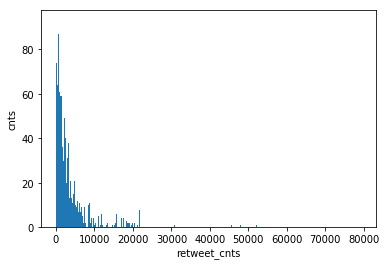

In [45]:
df_twt_json['retweet_count'].plot(kind='hist', bins=1000)
plt.xlabel('retweet_cnts')
plt.ylabel('cnts')
plt.show()

In [46]:
df_twt_json['favorite_count'].isnull().value_counts()

False    2944
Name: favorite_count, dtype: int64

In [47]:
df_twt_json['favorite_count'].value_counts()

0       120
6688      6
1788      5
2476      5
2231      5
       ... 
417       1
419       1
173       1
869       1
2068      1
Name: favorite_count, Length: 1859, dtype: int64

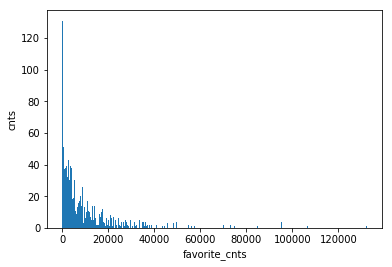

In [48]:
df_twt_json['favorite_count'].plot(kind='hist',bins=1000)
plt.xlabel('favorite_cnts')
plt.ylabel('cnts')
plt.show()

#### 评估df_img_pre

In [49]:
display.display(df_img_pre)
display.display(df_img_pre.describe())
for k, v in df_img_pre.dtypes.iteritems():
    print(k, '\t\t', v)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.5,True,collie,0.2,True,Shetland_sheepdog,0.1,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.5,True,miniature_pinscher,0.1,True,Rhodesian_ridgeback,0.1,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.6,True,malinois,0.1,True,bloodhound,0.1,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.4,True,redbone,0.4,True,miniature_pinscher,0.2,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.6,True,Rottweiler,0.2,True,Doberman,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.6,True,English_springer,0.2,True,German_short-haired_pointer,0.2,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.2,False,Labrador_retriever,0.2,True,spatula,0.0,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.7,True,malamute,0.1,True,kelpie,0.0,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.3,True,Pekinese,0.1,True,papillon,0.1,True


,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2075.0,2075.0,2075.0,2075.0,2075.0
mean,738451357852529152.0,1.2,0.6,0.1,0.1
std,67852033330235664.0,0.6,0.3,0.1,0.1
min,666020888022790144.0,1.0,0.0,0.0,0.0
25%,676483507139540992.0,1.0,0.4,0.1,0.0
50%,711998809858043904.0,1.0,0.6,0.1,0.0
75%,793203448525178880.0,1.0,0.8,0.2,0.1
max,892420643555336192.0,4.0,1.0,0.5,0.3


tweet_id 		 int64
jpg_url 		 object
img_num 		 int64
p1 		 object
p1_conf 		 float64
p1_dog 		 bool
p2 		 object
p2_conf 		 float64
p2_dog 		 bool
p3 		 object
p3_conf 		 float64
p3_dog 		 bool


In [50]:
df_img_pre.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [51]:
df_img_pre['tweet_id'].isnull().value_counts()

False    2075
Name: tweet_id, dtype: int64

In [52]:
df_img_pre['tweet_id'].duplicated().value_counts()

False    2075
Name: tweet_id, dtype: int64

In [53]:
df_img_pre['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [54]:
df_img_pre[['p1', 'p1_conf', 'p1_dog']].sample(5)

,p1,p1_conf,p1_dog
1525,golden_retriever,0.8,True
1180,keeshond,0.9,True
148,Pekinese,0.6,True
62,golden_retriever,0.5,True
862,Great_Dane,0.2,True


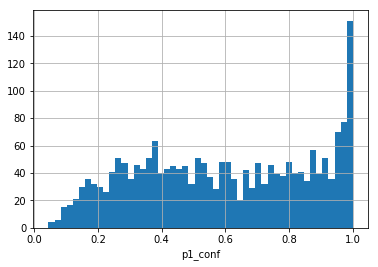

In [55]:
df_img_pre['p1_conf'].hist(bins=50)
plt.xlabel('p1_conf')
plt.show()

kinds of predicted dogs: 111
number of predicted dogs: 1532


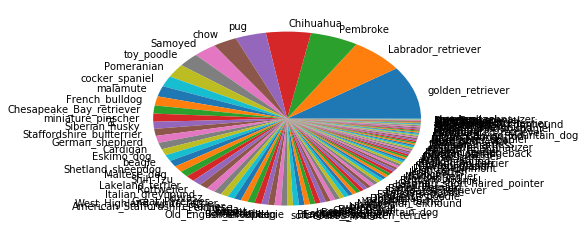

In [56]:
# 狗的种类有多少种？
print("kinds of predicted dogs: %r" % len(df_img_pre[df_img_pre['p1_dog'] == True]['p1'].value_counts()))
print("number of predicted dogs: %r" % df_img_pre[df_img_pre['p1_dog'] == True]['p1'].value_counts().sum())
df_img_pre[df_img_pre['p1_dog'] == True]['p1'].value_counts().plot(kind='pie')
plt.show()

**整洁问题2**： 

将3个表描述的是同一个事，应合并成一个表

### 2. 对项目数据进行清洗
对你在评估时列出的每个问题进行清洗，展示清洗的过程。结果应该为一个优质干净整洁的主数据集（pandas DataFrame 类型）

**质量问题1**：  
1. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 的数据格式应该是int64
2. 存在转发的条目需要删除
3. 存在无图片的推特需要删除
4. 分子出现极端值 1776  
5. 分子单位不一致，即不为 1/10
6. 分数提取不全正确
7. 部分名字提取不正确，有 765个"None" 和 67个"a"，,还有一个叫'space'，不是大写，可能有问题
8. 根据项目介绍，狗狗的stage不全，还有"blep", "snoot" ,"BlepiPen" 
9. stage提取出错：
有些时候n_stage为0；  
还有些情况，存在狗狗有两个stage，查看后，发现这种情况对应的情况包括：图片中有2只狗狗、作者进行比较的时候提及了另一stage等。
10. 漏将floof归类为floofer
11. df_twt_json表格的tweet_id 存在重复

**整洁问题1**：
1. 不应该将狗的stage分成doggo、floofer、pupper、puppo四列，以独热编码方式记录，应该记为一列‘stage’，而为真的原列名为内容。
2. 需要将三个表合为一张表。

#### 提前备份原始数据


In [57]:
df_tae_copy = df_tae.copy()
df_twt_json_copy = df_twt_json.copy()
df_img_pre_copy = df_img_pre.copy()

#### 对数据集逐个进行清洗

##### 1. df_tae_copy



**质量问题1**：  
in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 的数据格式应该是int64

In [58]:
col_tmp = ['in_reply_to_status_id', 
           'in_reply_to_user_id', 
           'retweeted_status_id', 
           'retweeted_status_user_id']
df_tae_copy[col_tmp] = df_tae_copy[col_tmp].apply(np.int64)

In [59]:
df_tae_copy[col_tmp].dtypes

in_reply_to_status_id       int64
in_reply_to_user_id         int64
retweeted_status_id         int64
retweeted_status_user_id    int64
dtype: object

**质量问题2**：  
存在转发的条目需要删除

In [60]:
df_tae_copy[~df_tae_copy.retweeted_status_timestamp.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage
19,888202515573088257,-9223372036854775808,-9223372036854775808,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,887473957103951872,4196983835,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None,613.1,0.0
32,886054160059072513,-9223372036854775808,-9223372036854775808,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,886053734421102592,19607400,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None,607.2,0.0
36,885311592912609280,-9223372036854775808,-9223372036854775808,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,830583320585068544,4196983835,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None,605.1,0.0
68,879130579576475649,-9223372036854775808,-9223372036854775808,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,878057613040115712,4196983835,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None,588.1,0.0
73,878404777348136964,-9223372036854775808,-9223372036854775808,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,878281511006478336,4196983835,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None,586.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,-9223372036854775808,-9223372036854775808,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,667866724293877760,4196983835,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None,222.1,0.0
1043,743835915802583040,-9223372036854775808,-9223372036854775808,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,667138269671505920,4196983835,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None,214.7,0.0
1242,711998809858043904,-9223372036854775808,-9223372036854775808,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,711998279773347840,783214,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None,126.9,0.0
2259,667550904950915073,-9223372036854775808,-9223372036854775808,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,667548695664070656,4296831739,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None,4.2,0.0


In [61]:
df_tae_copy[~df_tae_copy.retweeted_status_timestamp.isnull()].index.values

array([  19,   32,   36,   68,   73,   74,   78,   91,   95,   97,  101,
        109,  118,  124,  130,  132,  137,  146,  155,  159,  160,  165,
        171,  180,  182,  185,  194,  195,  204,  211,  212,  222,  230,
        231,  247,  250,  260,  266,  272,  273,  281,  285,  286,  289,
        298,  302,  303,  307,  309,  310,  319,  327,  332,  340,  341,
        343,  357,  359,  366,  382,  386,  397,  399,  406,  411,  415,
        420,  422,  425,  431,  434,  435,  438,  446,  447,  450,  453,
        455,  462,  465,  469,  475,  476,  479,  485,  488,  506,  522,
        530,  535,  538,  541,  543,  546,  552,  555,  558,  561,  566,
        568,  574,  577,  581,  583,  586,  589,  594,  595,  596,  597,
        598,  599,  600,  601,  602,  603,  604,  605,  606,  612,  615,
        618,  627,  629,  634,  654,  655,  656,  661,  664,  669,  671,
        677,  682,  686,  692,  694,  702,  720,  728,  741,  742,  745,
        749,  753,  759,  764,  767,  770,  773,  7

In [62]:
df_tae_copy.drop(labels=df_tae_copy[~df_tae_copy.retweeted_status_timestamp.isnull()].index, axis=0, inplace=True)

In [63]:
df_tae_copy[~df_tae_copy.retweeted_status_timestamp.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage


**质量问题3**：  
存在无图片的推特需要删除

In [64]:
df_tae_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'ts', 'n_stage'],
      dtype='object')

In [65]:
len(df_tae_copy[df_tae_copy.expanded_urls.isnull()])

58

In [66]:
df_tae_copy.drop(labels=df_tae_copy[df_tae_copy.expanded_urls.isnull()].index, axis=0, inplace=True)

In [67]:
len(df_tae_copy[df_tae_copy.expanded_urls.isnull()])

0

**质量问题4**

分子出现极端值 1776  

**质量问题5**

分子单位不一致，即不为 1/10

**质量问题6**

分数提取不全正确

In [68]:
df_tae_copy[df_tae_copy['rating_numerator'] > 15]['rating_numerator'].value_counts()

60     1
143    1
420    1
165    1
80     1
      ..
144    1
24     1
121    1
26     1
99     1
Name: rating_numerator, Length: 19, dtype: int64

我们发现15分是一个合理的分界线，大于它的分值属于离群值，值得我们进一步注意

In [69]:
df_tae_copy[df_tae_copy['rating_numerator'] > 15][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
902,Why does this never happen at my front door......,165,150
...,...,...,...
1635,Someone help the girl is being mugged. Several...,121,110
1712,Here we have uncovered an entire battalion of ...,26,10
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1843,Here we have an entire platoon of puppers. Tot...,88,80


可以发现有的高分是真实的，有些是提取错误。我们应该再看看分母帮助我们进行判断。  
我们重点考察下面的数据

In [70]:
df_tmp_rating = df_tae_copy[(df_tae_copy['rating_numerator'] > 15) | (df_tae_copy['rating_denominator'] != 10)][['text', 'rating_numerator', 'rating_denominator']]
df_tmp_rating

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
902,Why does this never happen at my front door......,165,150
...,...,...,...
1712,Here we have uncovered an entire battalion of ...,26,10
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120
1843,Here we have an entire platoon of puppers. Tot...,88,80
2074,After so many requests... here you go.\r\n\r\n...,420,10


我们重新仔细提取text中的分数，进行对比

In [71]:
import re
 
p = re.compile(r'\d{0,2}\.?\d{1,5}/\d{1,3}')

for i, row in df_tmp_rating.iterrows():
    tmp_ls = []
    for m in p.finditer(row['text']):
#         print(m.group())
        tmp_ls.append(m.group())
    print(tmp_ls)

['84/70']
['24/7']
['9.75/10']
['11.27/10']
['165/150']
['1776/10']
['9/11', '14/10']
['204/170']
['4/20', '13/10']
['50/50', '11/10']
['99/90']
['80/80']
['45/50']
['60/50']
['44/40']
['143/130']
['121/110']
['7/11', '10/10']
['11.26/10']
['144/120']
['88/80']
['420/10']
['1/2', '9/10']


目前发现的有三类错误：  
1. 由于没有提取到小数点前的数字导致的；
2. 有其他缩写导致没有提取到指定的分数；
3. 由于图片中有几条狗，分数可能是10的整倍数

也有可能 text 中就是没有分数

我们对数据进行重新提取

发现可以通过直接取最后一个进行解决

In [72]:
df_tae_copy[['rating_numerator']] = df_tae_copy[['rating_numerator']].apply(np.float64)
df_tae_copy['rating_numerator'].dtype

dtype('float64')

In [73]:
p = re.compile(r'\d{0,4}\.?\d{1,4}/\d{1,4}')

for i, row in df_tae_copy[(df_tae_copy['rating_numerator'] > 15) | (df_tae_copy['rating_denominator'] != 10)].iterrows():
    tmp_ls = []
    for m in p.finditer(row['text']):
        tmp_ls.append(m.group())
    # 将提取失败的用分子0，分母0进行标记
    if len(tmp_ls) == 0:
        df_tae_copy.loc[i, 'rating_numerator'] = np.float64(0)
        df_tae_copy.loc[i, 'rating_denominator'] = np.int64(0)
    elif len(tmp_ls) == 1:
        n, d = tmp_ls[0].split('/')
        df_tae_copy.loc[i, 'rating_numerator'] = np.float64(n)
        df_tae_copy.loc[i, 'rating_denominator'] = np.int64(d)
    else:
        df_tae_copy.loc[i, 'rating_numerator'] = np.float64(0)
        df_tae_copy.loc[i, 'rating_denominator'] = np.int64(0)
        for e in tmp_ls:
            n, d = e.split('/')
            n = np.float64(n)
            d = np.int64(d)
            exist_10 = False
            exist_mod10 = False
            
            if d == 10:
                exist_10 = True
                n10 = n
                d10 = d
            elif d>0 and d%10 == 0:
                exist_mod10 = True
                nmod10 = n
                dmod10 = d
        if exist_mod10:
            df_tae_copy.loc[i, 'rating_numerator'] = np.float64(nmod10)
            df_tae_copy.loc[i, 'rating_denominator'] = np.int64(dmod10)            
        if exist_10:
            df_tae_copy.loc[i, 'rating_numerator'] = np.float64(n10)
            df_tae_copy.loc[i, 'rating_denominator'] = np.int64(d10)

没有提取失败的

In [74]:
df_tae_copy[(df_tae_copy['rating_numerator'] == 0 ) & (df_tae_copy['rating_denominator'] == 0)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage


再看看是否还有异常值，23-> 15，减少了8个，我们把异常的情况打印出来

In [75]:
df_tmp_rating = df_tae_copy[(df_tae_copy['rating_numerator'] > 15) | (df_tae_copy['rating_denominator'] != 10)]
df_tmp_rating[['text','rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the flo...,84.0,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7
902,Why does this never happen at my front door......,165.0,150
979,This is Atticus. He's quite simply America af....,1776.0,10
1120,Say hello to this unbelievably well behaved sq...,204.0,170
...,...,...,...
1634,"Two sneaky puppers were not initially seen, mo...",143.0,130
1635,Someone help the girl is being mugged. Several...,121.0,110
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144.0,120
1843,Here we have an entire platoon of puppers. Tot...,88.0,80


将分母为10的倍数的，进行分子分母统一规整到分母为10

In [76]:
for i, row in df_tmp_rating.iterrows():
    if row['rating_denominator']%10 == 0:
        df_tae_copy.loc[i, 'rating_numerator'] /= (row['rating_denominator']/10)
        df_tae_copy.loc[i, 'rating_denominator'] = np.int64(10)      

In [77]:
df_tmp_rating = df_tae_copy[(df_tae_copy['rating_numerator'] > 15) | (df_tae_copy['rating_denominator'] != 10)]
df_tmp_rating[['text','rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7
979,This is Atticus. He's quite simply America af....,1776.0,10
2074,After so many requests... here you go.\r\n\r\n...,420.0,10


In [78]:
for i, row in df_tmp_rating.iterrows():
    print(row['text'])

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY


发现只有第一条中的24/7是纯错误的，我们把这一条删掉即可

In [79]:
df_tmp_rating = df_tae_copy.drop(df_tae_copy[(df_tae_copy['rating_numerator'] == 24) & (df_tae_copy['rating_denominator'] == 7)].index,axis=0,inplace=True)
df_tae_copy[(df_tae_copy['rating_numerator'] == 24) & (df_tae_copy['rating_denominator'] == 7)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage


**质量问题7**：

部分名字提取不正确，有 765个"None" 和 67个"a"，,还有一个叫'space'，不是大写，可能有问题

但其实我对姓名并不感兴趣，发现提取失败的情况中除了非狗狗的情况并没有给我带来太大麻烦，再提取也没有必要。但我们需要把None这个字段标为Python内置的None，这样的话利于我们后续通过pandas自带的操作处理空值。

（因为我发现在没有搜到名字的情况中，存在相当的情况是由于用户传入的不是狗的图片，导致姓名列提取出错。我又发现在出错的情况中，text列中一般会有"only send dogs"和"we only rate dogs"的字样，通过提取'only'字眼，我们可以大概率去除非狗狗的照片，如果需要重新提取名字，可以参考这条）

In [80]:
df_tae_copy['name'].value_counts()

None       622
a           55
Lucy        11
Charlie     11
Cooper      10
          ... 
Tilly        1
Raphael      1
Oddie        1
Amélie       1
Quinn        1
Name: name, Length: 956, dtype: int64

In [81]:
# 首字母没有大写的 和 'None'
not_upper = lambda x: True if x[0].upper() != x[0] else False
df_tmp_name = df_tae_copy[(df_tae_copy['name'].apply(not_upper)) | (df_tae_copy['name'] == 'None')]
df_tmp_name

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage
5,891087950875897856,-9223372036854775808,-9223372036854775808,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,None,None,None,None,621.1,0.0
7,890729181411237888,-9223372036854775808,-9223372036854775808,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,None,None,None,None,620.1,0.0
12,889665388333682689,-9223372036854775808,-9223372036854775808,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/889665388...,13.0,10,None,None,None,None,puppo,617.1,1.0
22,887517139158093824,-9223372036854775808,-9223372036854775808,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/887517139...,14.0,10,such,None,None,None,None,611.2,0.0
24,887343217045368832,-9223372036854775808,-9223372036854775808,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/887343217...,13.0,10,None,None,None,None,None,610.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,-9223372036854775808,-9223372036854775808,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/666049248...,5.0,10,None,None,None,None,None,0.1,0.0
2352,666044226329800704,-9223372036854775808,-9223372036854775808,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/666044226...,6.0,10,a,None,None,None,None,0.1,0.0
2353,666033412701032449,-9223372036854775808,-9223372036854775808,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/666033412...,9.0,10,a,None,None,None,None,0.0,0.0
2354,666029285002620928,-9223372036854775808,-9223372036854775808,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/666029285...,7.0,10,a,None,None,None,None,0.0,0.0


In [82]:
for i, row in df_tmp_name.iterrows():
    df_tae_copy.loc[i, 'name'] = np.nan

In [83]:
df_tmp_name = df_tae_copy[(df_tae_copy['name'] == 'None')]
df_tmp_name

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage


In [84]:
df_tae_copy['name'].isnull().value_counts()

False    1390
True      726
Name: name, dtype: int64

**质量问题8**：

根据项目介绍，狗狗的stage不全，还有"blep", "snoot" ,"BlepiPen" 

通过对上述情况进行查看，发现'BlepiPen'的标签非常少见，只有3个，没有分析价值。可以删去。故我们可以认为狗狗的stage只有4类。

In [85]:
# 从df['text']中找到'blep'和'snoot'
def blep_or_snoot(s):
    if ('blep' in s.lower()) or ('snoot' in s.lower()) or ('blepipen' in s.lower()) :
        return True
    else:
        return False
df_blep_or_snoot = df_tae_copy.text.apply(blep_or_snoot)
df_blep_or_snoot.value_counts()

False    2112
True        4
Name: text, dtype: int64

因为这些情况太少了（只有4个），即使标记出来也没统计意义，故不作处理

**质量问题9**：

stage提取出错

有些时候n_stage为0；  
还有些情况，存在狗狗有两个stage，查看后，发现这种情况对应的情况包括：图片中有2只狗狗、作者进行比较的时候提及了另一stage等。

In [86]:
# 创建一列新的列名为'num_stage'，其内容为doggo、floofer、pupper、puppo列中不为None的个数
for i, row in df_tae_copy.iterrows():
    cols = ['doggo', 'floofer', 'pupper','puppo']
#     cols = [6,7,8,9]
    n_stage = 0
    for col in cols:
        if row[col] != 'None':
            n_stage += 1
    df_tae_copy.loc[i, 'n_stage'] = n_stage

print(df_tae_copy['n_stage'].value_counts())

for i,v in df_tae_copy[df_tae_copy['n_stage'] == 2].iterrows():
    print(i, '\t', v['text'])

0.0    1778
1.0     326
2.0      12
Name: n_stage, dtype: int64
191 	 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
200 	 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk
460 	 This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
531 	 Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
565 	 Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
575 	 This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
705 	 This is Pinot. He's a sophisticated doggo. Yo

**质量问题10**：

漏将floof归类为floofer

In [87]:
def with_floof(s):
    return True if 'floof' in s.lower() else False

for i,row in df_tae_copy.iterrows():
    if with_floof(row['text']):
        df_tae_copy.loc[i, 'floofer'] = 'floofer'
df_tae_copy[df_tae_copy.floofer != 'None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,ts,n_stage
25,887101392804085760,-9223372036854775808,-9223372036854775808,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/887101392...,12.0,10,NaN,None,floofer,None,None,610.1,0.0
46,883360690899218434,-9223372036854775808,-9223372036854775808,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/883360690...,13.0,10,Grizzwald,None,floofer,None,None,599.7,1.0
53,881906580714921986,-9223372036854775808,-9223372036854775808,2017-07-03 16:04:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rey. He's a Benebop Cumberfloof. 12/10...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/881906580...,12.0,10,Rey,None,floofer,None,None,595.7,0.0
200,854010172552949760,-9223372036854775808,-9223372036854775808,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/854010172...,11.0,10,NaN,doggo,floofer,None,None,518.8,2.0
433,820690176645140481,-9223372036854775808,-9223372036854775808,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/820690176...,12.0,10,NaN,None,floofer,None,None,426.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,690735892932222976,-9223372036854775808,-9223372036854775808,2016-01-23 03:20:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Peaches. She's a Dingleberry Zand...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/690735892...,13.0,10,Peaches,None,floofer,None,None,68.2,0.0
1534,689993469801164801,-9223372036854775808,-9223372036854775808,2016-01-21 02:10:37 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a rare High Stepping Al...,-9223372036854775808,-9223372036854775808,NaN,https://vine.co/v/ienexVMZgi5,12.0,10,NaN,None,floofer,None,None,66.2,1.0
1539,689661964914655233,-9223372036854775808,-9223372036854775808,2016-01-20 04:13:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Luca. He's a Butternut Scooperfloof. Glor...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/689661964...,12.0,10,Luca,None,floofer,None,None,65.2,0.0
1597,686050296934563840,-9223372036854775808,-9223372036854775808,2016-01-10 05:01:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Flávio. He's a Macedonian Poppycock. 9...,-9223372036854775808,-9223372036854775808,NaN,https://twitter.com/dog_rates/status/686050296...,11.0,10,Flávio,None,floofer,None,None,55.3,0.0


**整洁问题1**：

不应该将狗的stage分成doggo、floofer、pupper、puppo四列，以独热编码方式记录，应该记为一列‘stage’，而为真的原列名为内容。

将独热编码合并成一列

In [88]:
# 创建一列新的列名为'stage'，其内容为doggo、floofer、pupper、puppo或者None
for i, row in df_tae_copy.iterrows():
    cols = ['doggo', 'floofer', 'pupper','puppo']
    name = np.nan
    for col in cols:
        if row[col] != 'None':
            name = col
    df_tae_copy.loc[i, 'stage'] = name

print(df_tae_copy['stage'].value_counts())

pupper     232
doggo       71
floofer     38
puppo       24
Name: stage, dtype: int64


##### 2. df_twt_json_copy

**质量问题11**：

df_twt_json表格的tweet_id 存在重复

In [89]:
df_twt_json_copy[['tweet_id', 'img_num']].duplicated().value_counts()

False    2845
True       99
dtype: int64

根据之前的数据探索部分，我们知道去掉jpg_url重复的99条，剩下的就可以以tweet_id, img_num作为2级索引

In [90]:
df_twt_json_copy[df_twt_json_copy[['jpg_url']].duplicated()]

,tweet_id,jpg_url,img_num,retweet_count,favorite_count
163,868880397819494401,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,12435,54897
477,830583320585068544,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,19188,73157
478,830583320585068544,https://pbs.twimg.com/media/C4bTH6gWAAAV2ex.jpg,2,19188,73157
488,829374341691346946,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,10647,37930
489,829374341691346946,https://pbs.twimg.com/media/C4KHj-kWcAMSjF4.jpg,2,10647,37930
...,...,...,...,...,...
2540,673320132811366400,https://pbs.twimg.com/media/CVgdFj8XAAAwki9.jpg,4,8653,14374
2597,671896809300709376,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,4494,8955
2698,670444955656130560,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,2142,7091
2715,670319130621435904,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,1348,4087


In [91]:
df_twt_json_copy = df_twt_json_copy.drop_duplicates(subset=['jpg_url'],keep='first')

In [92]:
df_twt_json_copy[df_twt_json_copy[['jpg_url']].duplicated()]

,tweet_id,jpg_url,img_num,retweet_count,favorite_count


In [93]:
df_twt_json_copy[['tweet_id', 'img_num']].duplicated().value_counts()

False    2845
dtype: int64

##### 3. df_img_pre_copy

**整洁问题2**：

需要将三个表合为一张表。

In [94]:
df_twt_json_copy.shape

(2845, 5)

In [95]:
df_img_pre_copy.shape

(2075, 12)

In [96]:
df_main = df_twt_json_copy.merge(df_img_pre_copy, how='right', on=['tweet_id','img_num'])
df_main.shape

(2075, 15)

In [97]:
df_main = df_main.merge(df_tae_copy, how='left', on=['tweet_id'])
df_main.shape

(2075, 34)

### 3. 对项目数据进行存储、分析和可视化
将清理后的数据集存储到 CSV 文件中，命名为 twitter_archive_master.csv
可视化必须生成至少 3 个见解和 1 个可视化。

In [98]:
# 保存清洗和合并好的数据集
df_main.to_csv('twitter_archive_master.csv', index=False)

In [99]:
df_main.columns

Index(['tweet_id', 'jpg_url_x', 'img_num', 'retweet_count', 'favorite_count',
       'jpg_url_y', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'ts', 'n_stage', 'stage'],
      dtype='object')

In [100]:
# 去掉不需要的列，生成供数据可视化用的数据
col_need = ['tweet_id', # index 
            'img_num',  # 2nd index
            'ts',       # timestamp in day
#             'source', 
#             'text',
#             'expanded_urls', 
            'rating_numerator', 
            'rating_denominator', 
            'stage',    # doggo/floofer/pupper/puppo
#             'name',
#             'doggo', 
#             'floofer', 
#             'pupper', 
#             'puppo', 
#             'jpg_url_x', 'img_num_x',
            'retweet_count', 
            'favorite_count', 
#             'jpg_url_y', 'img_num_y', 
            'p1', 'p1_conf', 'p1_dog', # most likely prediction
            'p2', 'p2_conf', 'p2_dog' 
#             'p3', 'p3_conf', 'p3_dog'
           ]
df_sub = df_main[col_need]
display.display(df_sub)

,tweet_id,img_num,ts,rating_numerator,rating_denominator,stage,retweet_count,favorite_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog
0,892420643555336193,1,624.7,13.0,10.0,NaN,8842.0,39492.0,orange,0.1,False,bagel,0.1,False
1,892177421306343426,1,624.1,13.0,10.0,NaN,6480.0,33786.0,Chihuahua,0.3,True,Pekinese,0.1,True
2,891815181378084864,1,623.1,12.0,10.0,NaN,4301.0,25445.0,Chihuahua,0.7,True,malamute,0.1,True
3,891689557279858688,1,622.7,13.0,10.0,NaN,8925.0,42863.0,paper_towel,0.2,False,Labrador_retriever,0.2,True
4,891327558926688256,2,621.7,12.0,10.0,NaN,9721.0,41016.0,basset,0.6,True,English_springer,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,867072653475098625,1,nan,nan,nan,NaN,nan,nan,Blenheim_spaniel,0.4,True,papillon,0.2,True
2071,873697596434513921,1,nan,nan,nan,NaN,nan,nan,laptop,0.2,False,French_bulldog,0.1,True
2072,877611172832227328,1,nan,nan,nan,NaN,nan,nan,Irish_setter,0.4,True,golden_retriever,0.2,True
2073,885311592912609280,1,nan,nan,nan,NaN,nan,nan,Labrador_retriever,0.9,True,seat_belt,0.1,False


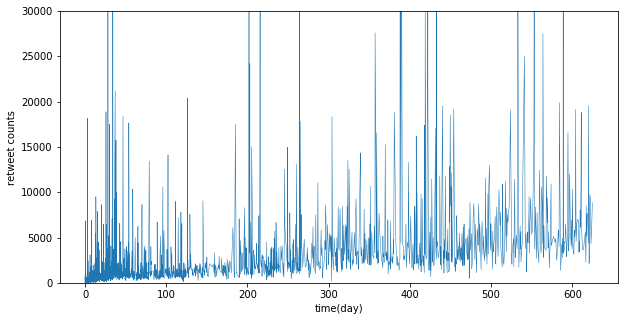

In [101]:
data = df_sub.copy()
data = data.sort_values(by='ts')
plt.figure(figsize=(10,5))
plt.plot(data.ts.values, data.retweet_count.values, linewidth=.5)
plt.xlabel('time(day)')
plt.ylabel('retweet counts')
plt.ylim((0, 30000))
plt.show()

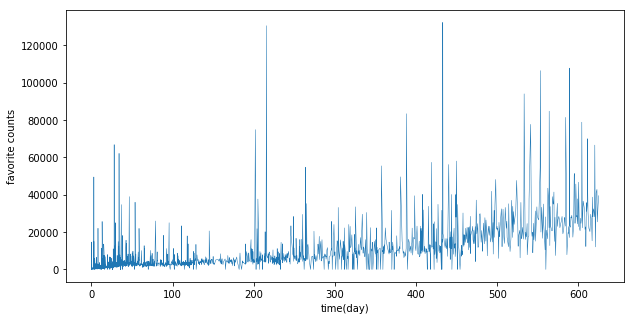

In [102]:
data = df_sub.copy()
data = data.sort_values(by='ts')
plt.figure(figsize=(10,5))
plt.plot(data.ts.values, data.favorite_count.values, linewidth=.5)
plt.xlabel('time(day)')
plt.ylabel('favorite counts')
# plt.ylim((0, 60000))
plt.show()

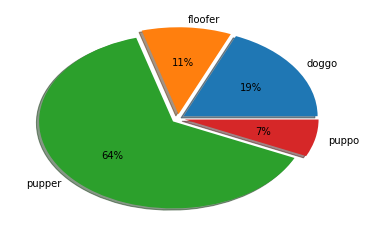

In [103]:
# data
labels = ['doggo', 'floofer', 'pupper','puppo']
data = df_sub['stage'].value_counts().loc[labels]
labels = data.index
fracs = data.values
explode = (0.05, 0.05, 0.05, 0.05)
plt.pie(fracs, explode=explode, labels=labels, autopct='%.0f%%', shadow=True)
plt.show()

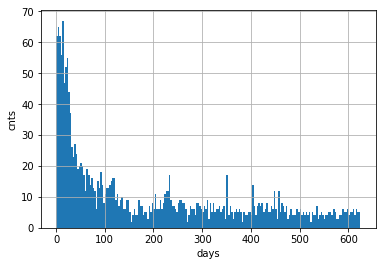

In [104]:
# twitter发送时间直方图
df_sub['ts'].hist(bins=200)
plt.xlabel('days')
plt.ylabel('cnts')
plt.show()

kinds of predicted dogs: 111
number of predicted dogs: 1532


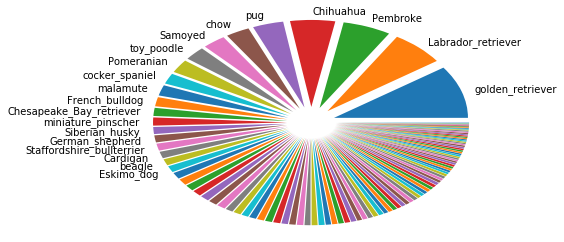

In [105]:
# 预测的狗的种类有多少种？
print("kinds of predicted dogs: %r" % len(df_sub[df_sub['p1_dog'] == True]['p1'].value_counts()))
print("number of predicted dogs: %r" % df_sub[df_sub['p1_dog'] == True]['p1'].value_counts().sum())
data = df_sub[df_sub['p1_dog'] == True]['p1'].value_counts()
labels = list(data.index.values[:20]) + [''] * (len(data) - 20)
plt.pie(data,
        labels=labels,
        explode=[0.18]*len(data)
       )
plt.show()

预测是否准确？
如果预测p1不正确，那么p2应该

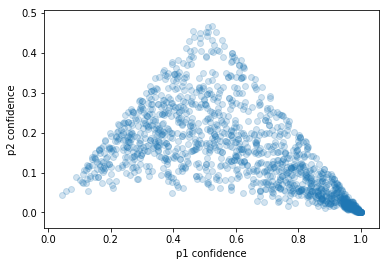

In [106]:
# 预测均为狗的时候，看预测p1的可信度和预测p2的可信度满足的关系，在[0,0.5]区间正相关，[0.5,1]区间负相关
data = df_sub[(df_sub['p1_dog'] == True) & (df_sub['p2_dog'] == True)]
plt.scatter(data.p1_conf, data.p2_conf, alpha = 0.2)
plt.xlabel("p1 confidence")
plt.ylabel("p2 confidence")
plt.show()

## 项目汇报

创建一个 **300-600字**的书面报告，命名为 wrangle_report.pdf，在该报告中简要描述你的数据整理过程。这份报告可以看作是一份内部文档，供你的团队成员查看交流。

创建一个 **250字以上**的书面报告，命名为 act_report.pdf，在该报告中，你可以与读者交流观点，展示你使用整理过的数据生成的可视化图表。这份报告可以看作是一份外部文档，如博客帖子或杂志文章。

## 项目提交
[审阅标准](https://review.udacity.com/#!/rubrics/1332/view)


包含以下文件，然后单击项目 workspace 页面右下角的“提交项目”：

- wrangle_act.ipynb：用于收集、评估、清洗、分析和可视化数据的代码
- wrangle_report.pdf：汇总数据整理步骤的文档：收集，评估和清洗
- act_report.pdf：对最终数据进行观察与分析的文档
- twitter_archive_enhanced.csv：给定的文件
- image_predictions.tsv：以编程方式下载的文件
- tweet_json.txt：通过 API 构建的文件
- twitter_archive_master.csv：合并与清洗后的数据